In [1]:
#Import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sb

In [2]:
#Reading the excel data using pandas
data = np.array(pd.read_excel('solar_data.xlsx'));

In [3]:
#Initializing the step operations by month and location
mon = np.linspace(1,12,12,dtype=int);
loc = np.linspace(0,236,237,dtype=int);
st = np.linspace(0,49,50,dtype=int);

In [4]:
#Parsing the latitude and state data
lat = data[:,3];
state_raw = data[:,1];

In [5]:
#Parsing the clearness index values
KT = data[:,4:];

In [6]:
#Useful constant
pi = np.pi;
dtr = pi/180;

In [7]:
#Matrix for land area of each state in sq. meters
area = np.array([1477953,131171,134771,294207,403466,268431,12542,5047,138887,148959,16635,144669,214945,143793,92789,211754,102269,111898,20201,25142,79883,146435,206232,178040,121531,376962,125920,178711,198974,23187,19047,314161,284332,122057,105829,177660,248608,115883,2678,77857,196350,106798,676587,212818,102279,23871,172119,140268,62259,251470])*1000000;

In [8]:
#Initializing the storage variables
H_o_bar_loc = np.zeros((237,12));
H_bar_loc = H_o_bar_loc;
H_bar_state = np.zeros((50,12));

In [9]:
#Beginning calculations by month by location
for i in mon:
	for j in loc:
		phi = lat[j];

		if i == 1:
			day = np.linspace(1,31,31);
			l = 31;
		elif i == 2:
			day = np.linspace(32,59,28);
			l = 28;
		elif i == 3:
			day = np.linspace(60,90,31);
			l = 31;
		elif i == 4:
			day = np.linspace(91,120,30);
			l = 30;
		elif i == 5:
			day = np.linspace(121,151,31);
			l = 31;
		elif i == 6:
			day = np.linspace(152,181,30);
			l = 30;
		elif i == 7:
			day = np.linspace(182,212,31);
			l = 31;
		elif i == 8:
			day = np.linspace(213,243,31);
			l = 31;
		elif i == 9:
			day = np.linspace(244,273,30);
			l = 30;
		elif i == 10:
			day = np.linspace(274,304,31);
			l = 31;
		elif i == 11:
			day = np.linspace(305,334,30);
			l = 30;
		else:
			day = np.linspace(335,365,31);
			l = 31;

		#Calculating the radiation on a horizontal surface for each day of the month
		H_o = np.linspace(0,l-1,l);
		a = 0; #step variable for storage
		for n in day:
			delta = 23.45 * np.sin(2*pi*(284+n)/365); #declination
			if -np.tan(phi*dtr)*np.tan(delta*dtr) > 1 or -np.tan(phi*dtr)*np.tan(delta*dtr) < -1:
				H_o[a] = 0;
			else:
				omega_s = np.degrees(np.arccos(-np.tan(phi*dtr)*np.tan(delta*dtr))); #sunset hour angle
				H_o[a] = (24*3600*1367/pi) * (1+0.033*np.cos(2*pi*n/365)) * ((np.cos(phi*dtr)*np.cos(delta*dtr)*np.sin(omega_s*dtr))+(omega_s*dtr*np.sin(phi*dtr)*np.sin(delta*dtr))); #radiation on a horizontal surface outside the Earth's atmosphere
			a = a + 1;

		#Take the daily average for the month and save
		H_o_bar_loc[j,i-1] = np.mean(H_o);

In [10]:
#Calculate surface radiation by location
H_bar_loc = np.multiply(KT,H_o_bar_loc); 

In [11]:
#Combine the values by state
for k in mon:
	p = -1;
	for m in st:
		n = 0;
		p = p+1;
		while state_raw[p] == state_raw[p+1] and p < 235:
			p = p+1;
			n = n+1;
		H_bar_state[m,k-1] = np.mean(H_bar_loc[p-n:p+1,k-1])/1000000;

In [12]:
#Sorting by state
state = [];
for q in state_raw:
	if q not in state:
		state.append(q);
state = np.transpose(state);

In [13]:
#Combine for all months and create data frame
H_bar_state_year = np.mean(H_bar_state, axis=1);
d_year = {'State': state, 'Value': H_bar_state_year};
df_year = pd.DataFrame(data=d_year);

In [14]:
#Import map and get rid of unneeded parts
sb.set(style="darkgrid");
mp = 'cb_2018_us_state_5m.shp';
US = gpd.read_file(mp);
US = US.drop(index=39);
US = US.drop(index=46);
US = US.drop(index=47);
US = US.drop(index=48);
US = US.drop(index=49);
US = US.drop(index=51);

In [15]:
#Merge dataset and dataframe
merged_year = US.set_index('STUSPS').join(df_year.set_index('State'))
merged_year = merged_year.reset_index();

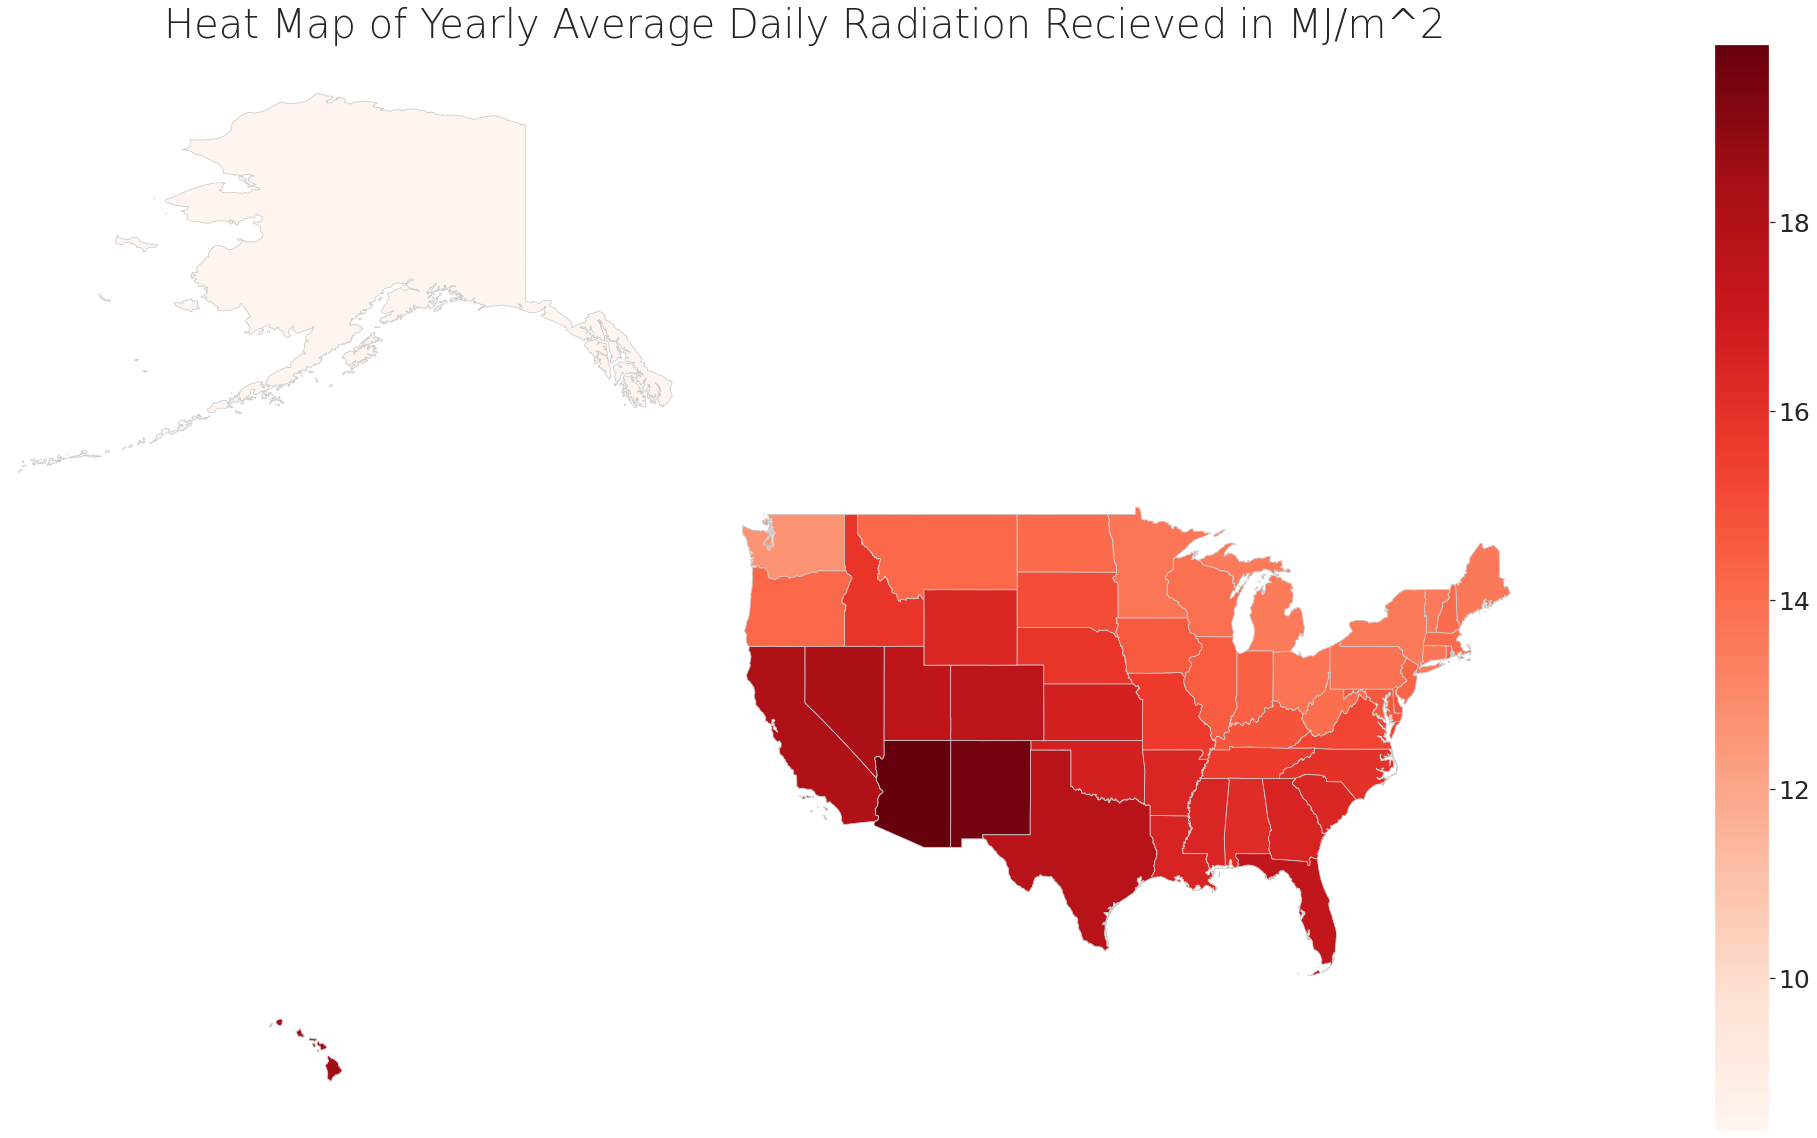

In [16]:
#Plot the heat map for daily average for the year
fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Yearly Average Daily Radiation Recieved in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_year = df_year['Value'];
vmin = col_year.min();
vmax = col_year.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_year.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

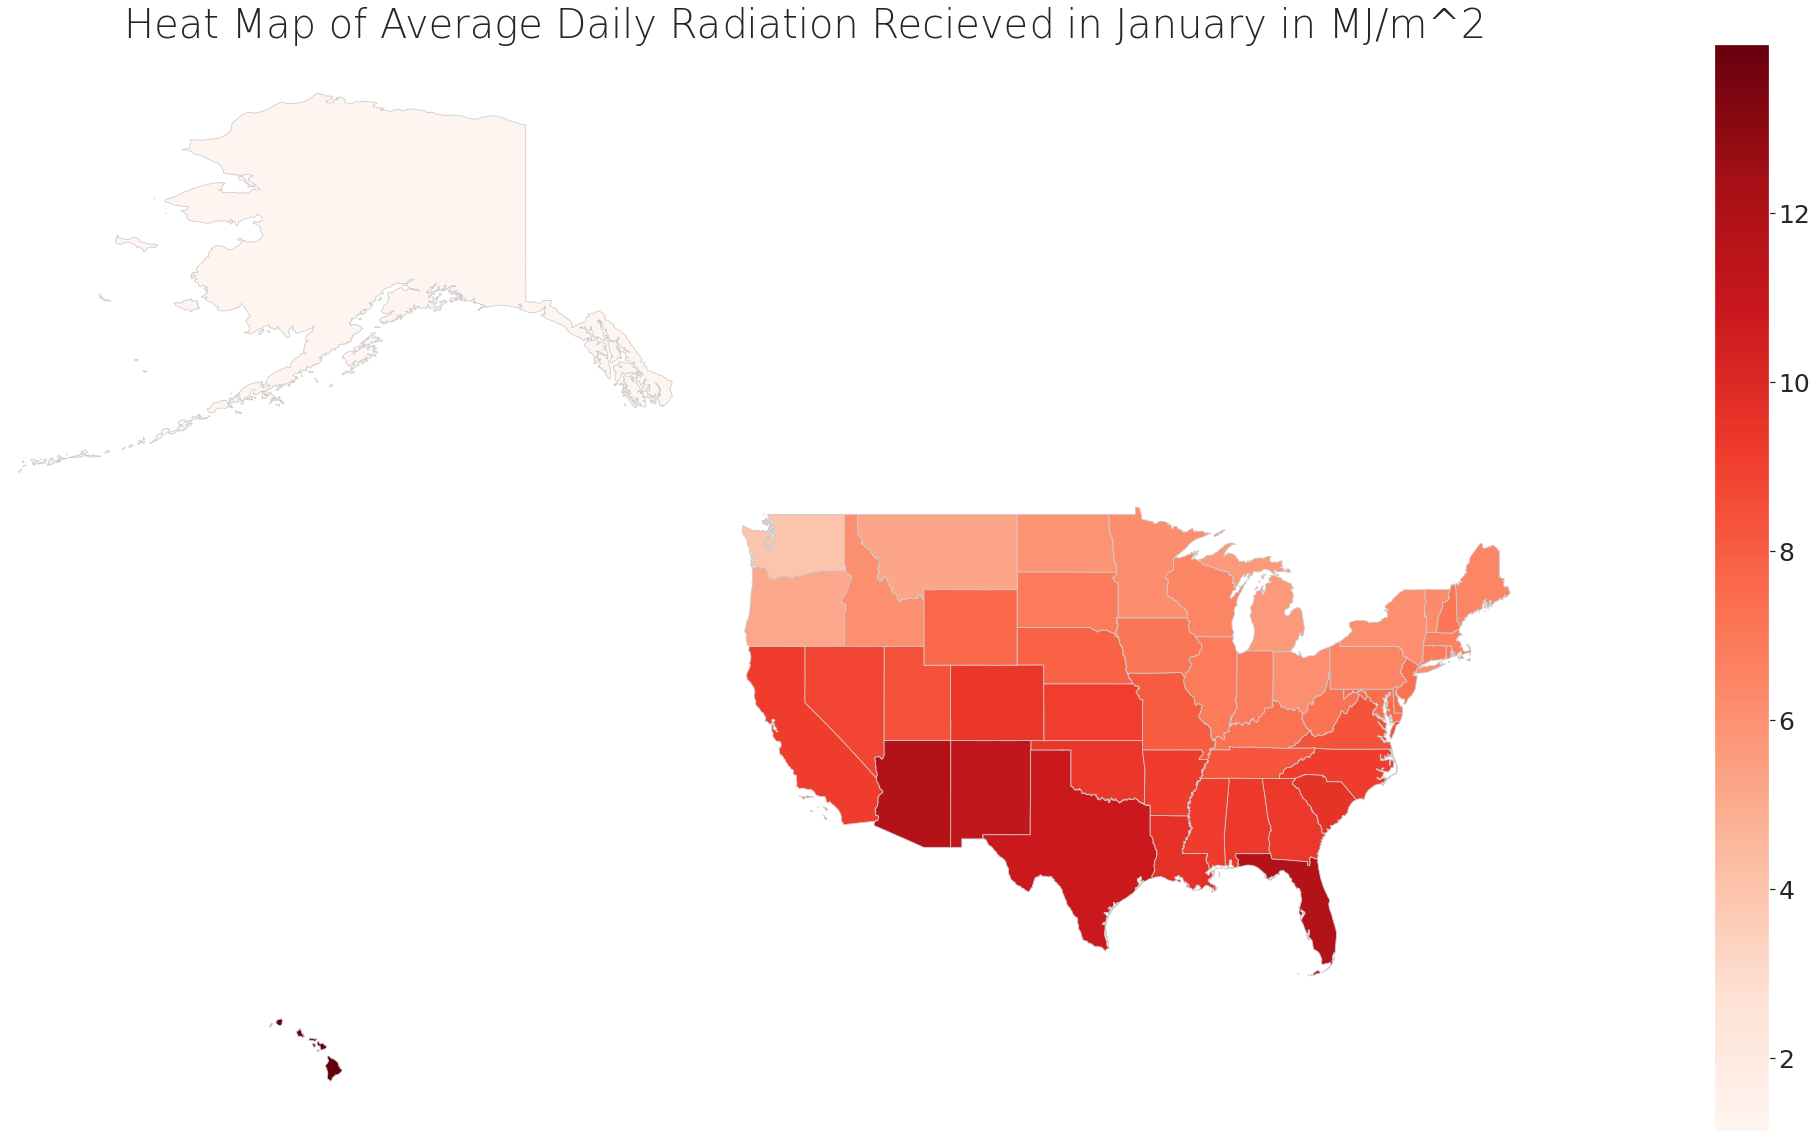

In [17]:
#Repeat by monthy daily average for January
H_bar_state_jan = H_bar_state[:,0];
d_jan = {'State': state, 'Value': H_bar_state_jan};
df_jan = pd.DataFrame(data=d_jan);

merged_jan = US.set_index('STUSPS').join(df_jan.set_index('State'))
merged_jan = merged_jan.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in January in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_jan = df_jan['Value'];
vmin = col_jan.min();
vmax = col_jan.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_jan.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

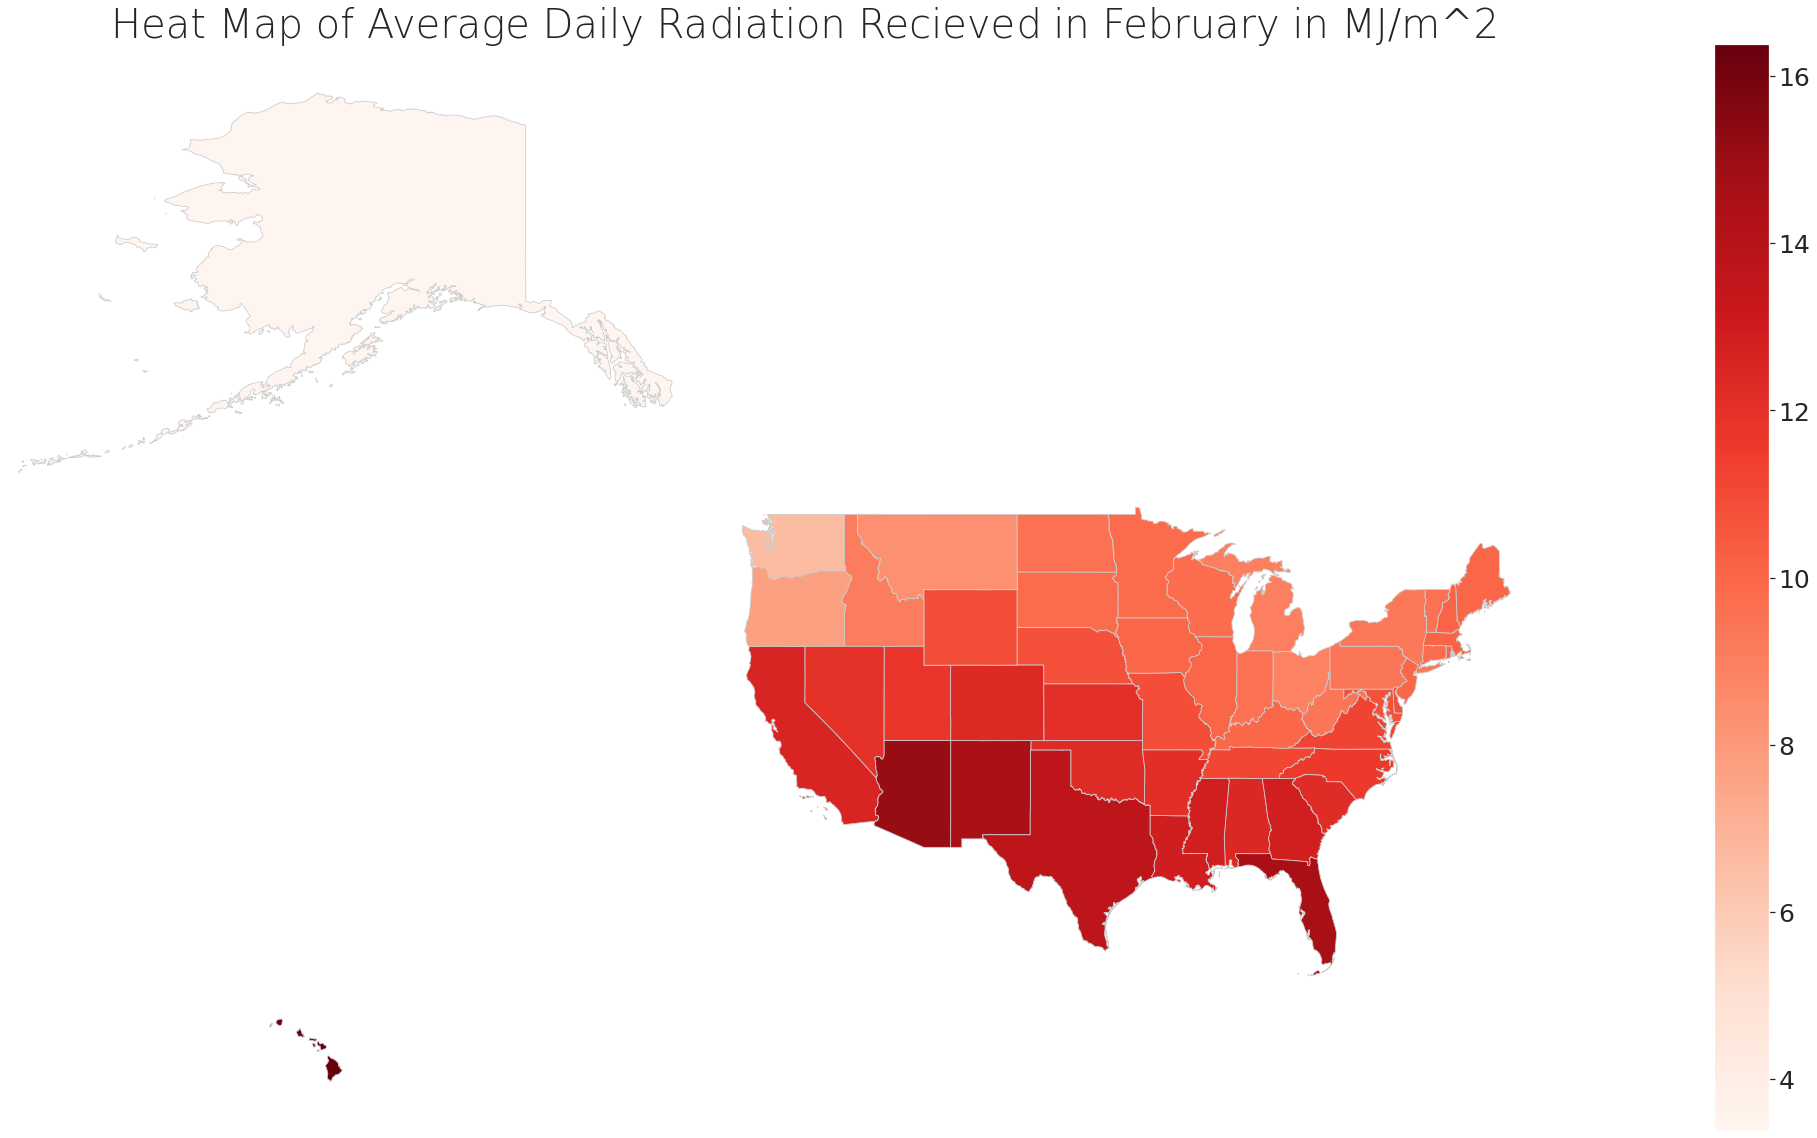

In [18]:
#Repeat by monthy daily average for February
H_bar_state_feb = H_bar_state[:,1];
d_feb = {'State': state, 'Value': H_bar_state_feb};
df_feb = pd.DataFrame(data=d_feb);

merged_feb = US.set_index('STUSPS').join(df_feb.set_index('State'))
merged_feb = merged_feb.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in February in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_feb = df_feb['Value'];
vmin = col_feb.min();
vmax = col_feb.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_feb.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

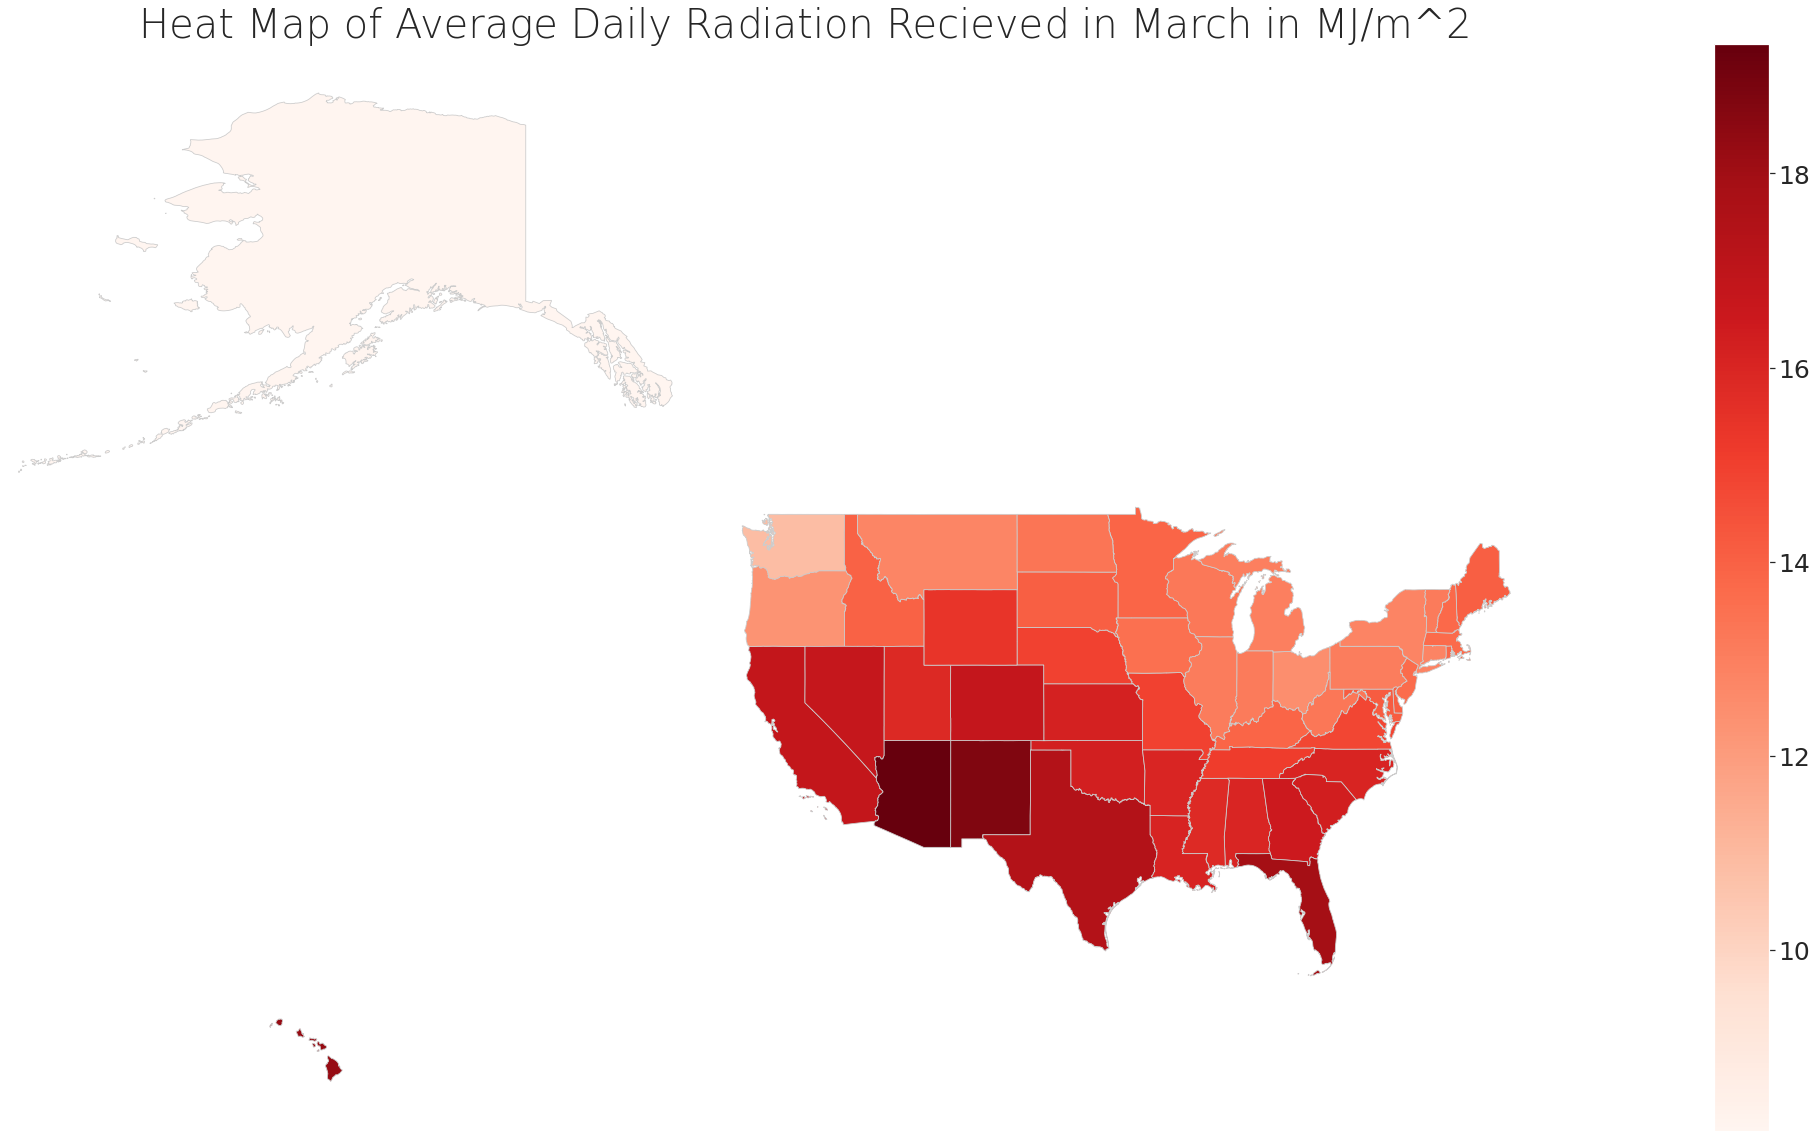

In [19]:
#Repeat by monthy daily average for March
H_bar_state_mar = H_bar_state[:,2];
d_mar = {'State': state, 'Value': H_bar_state_mar};
df_mar = pd.DataFrame(data=d_mar);

merged_mar = US.set_index('STUSPS').join(df_mar.set_index('State'))
merged_mar = merged_mar.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in March in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_mar = df_mar['Value'];
vmin = col_mar.min();
vmax = col_mar.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_mar.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

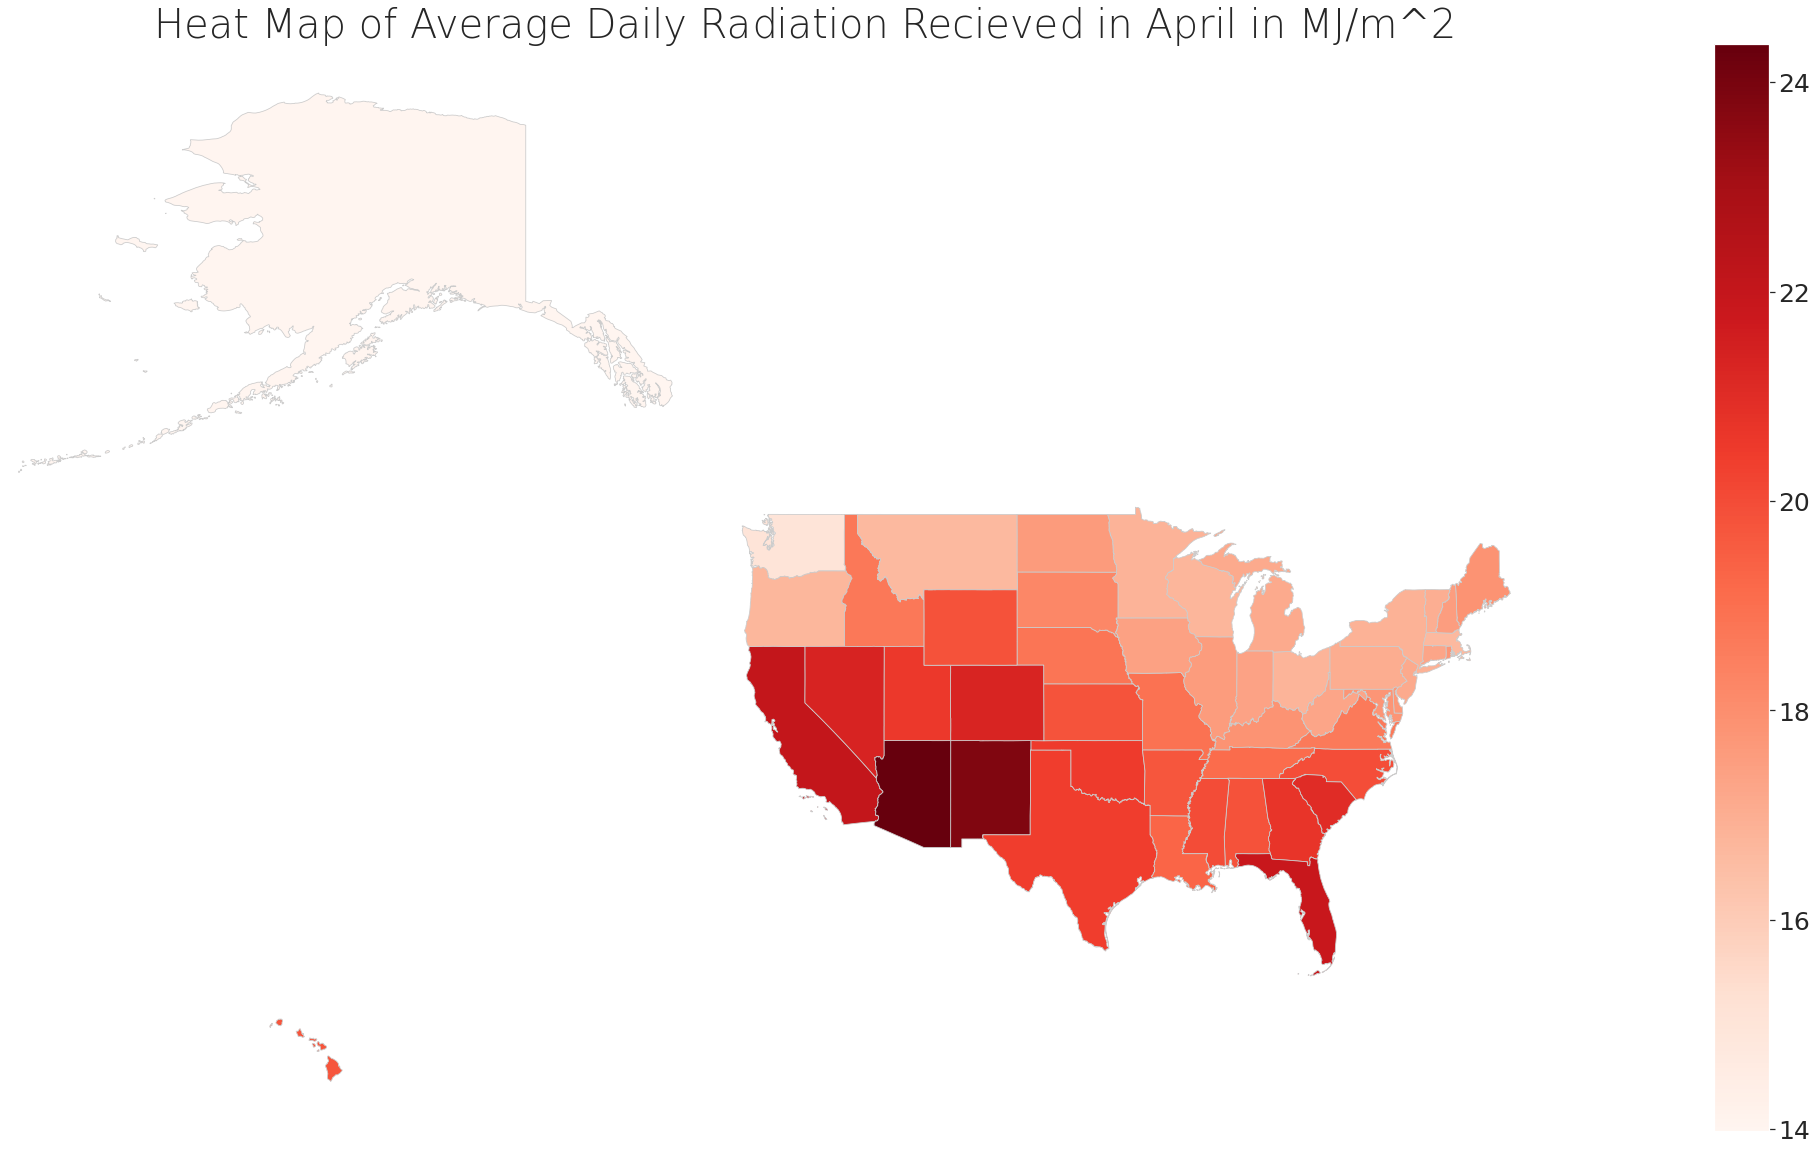

In [20]:
#Repeat by monthy daily average for April
H_bar_state_apr = H_bar_state[:,3];
d_apr = {'State': state, 'Value': H_bar_state_apr};
df_apr = pd.DataFrame(data=d_apr);

merged_apr = US.set_index('STUSPS').join(df_apr.set_index('State'))
merged_apr = merged_apr.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in April in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_apr = df_apr['Value'];
vmin = col_apr.min();
vmax = col_apr.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_apr.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

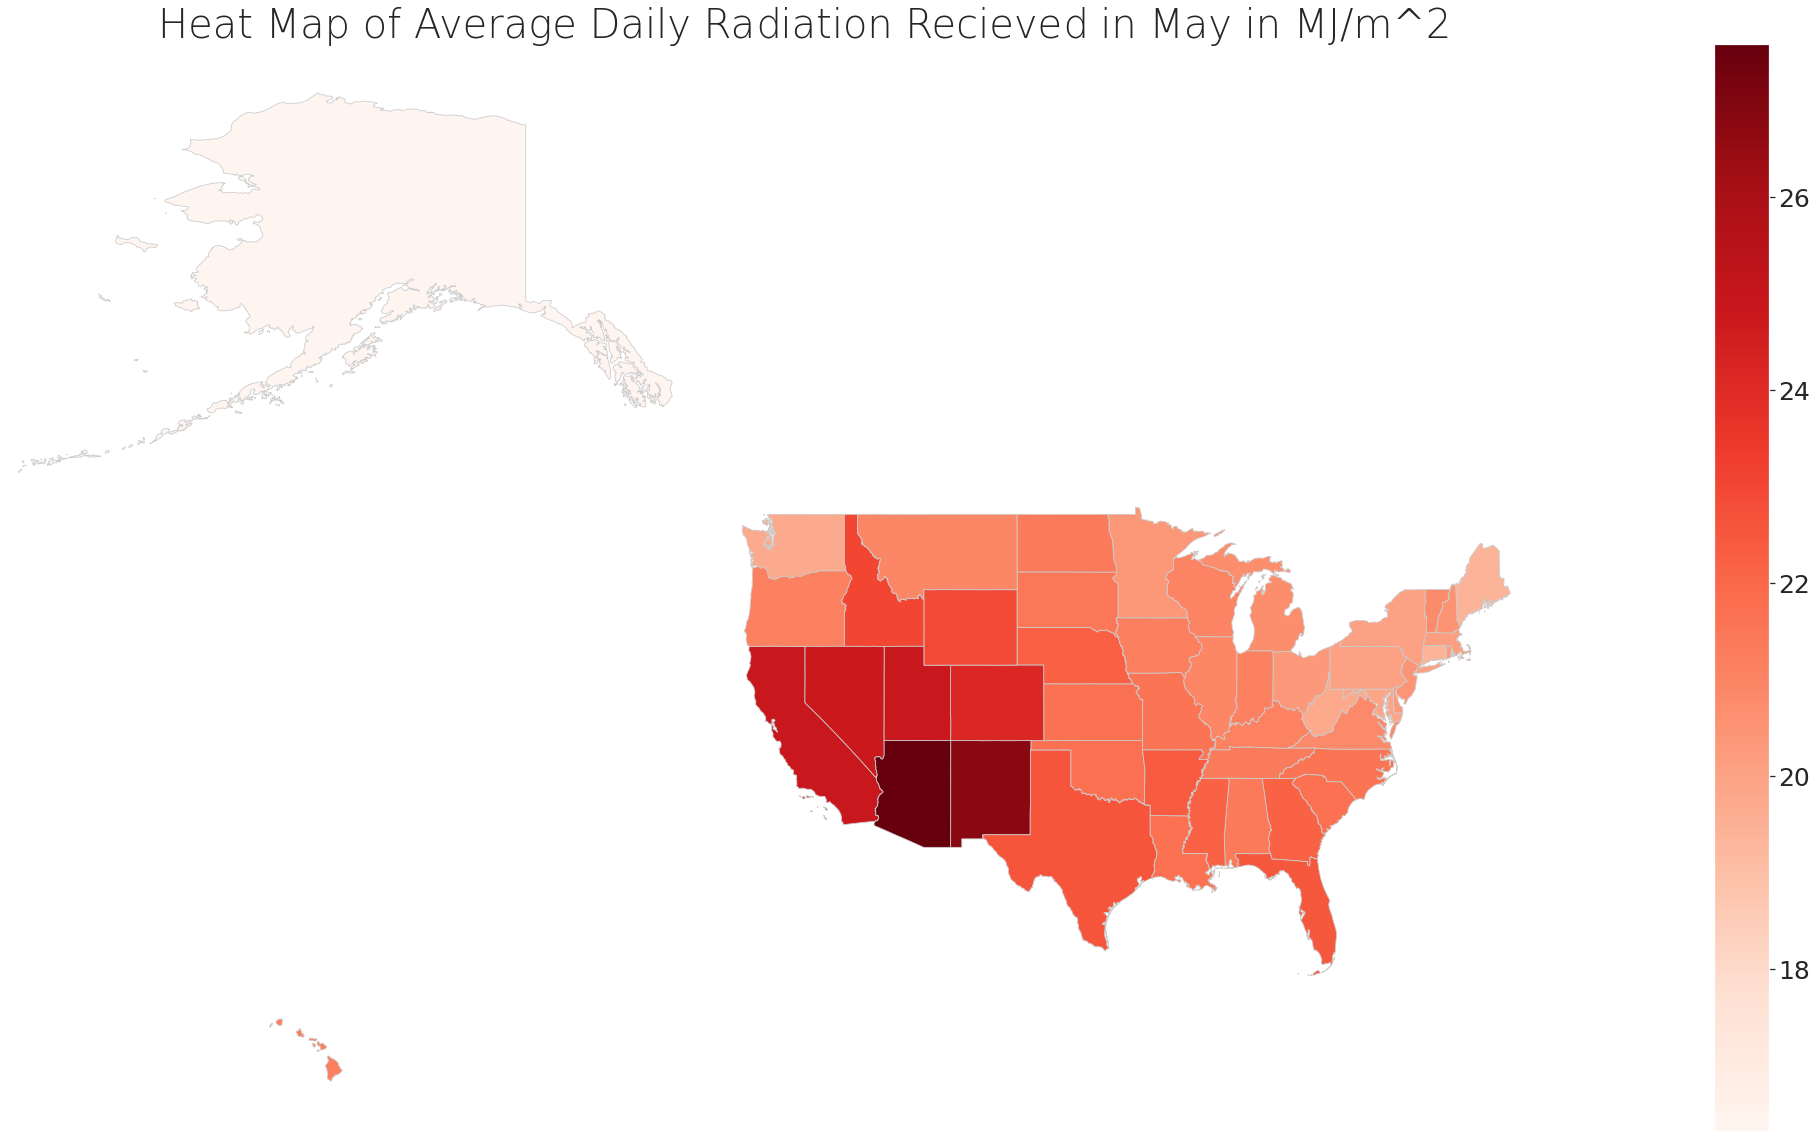

In [21]:
#Repeat by monthy daily average for May
H_bar_state_may = H_bar_state[:,4];
d_may = {'State': state, 'Value': H_bar_state_may};
df_may = pd.DataFrame(data=d_may);

merged_may = US.set_index('STUSPS').join(df_may.set_index('State'))
merged_may = merged_may.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in May in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_may = df_may['Value'];
vmin = col_may.min();
vmax = col_may.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_may.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

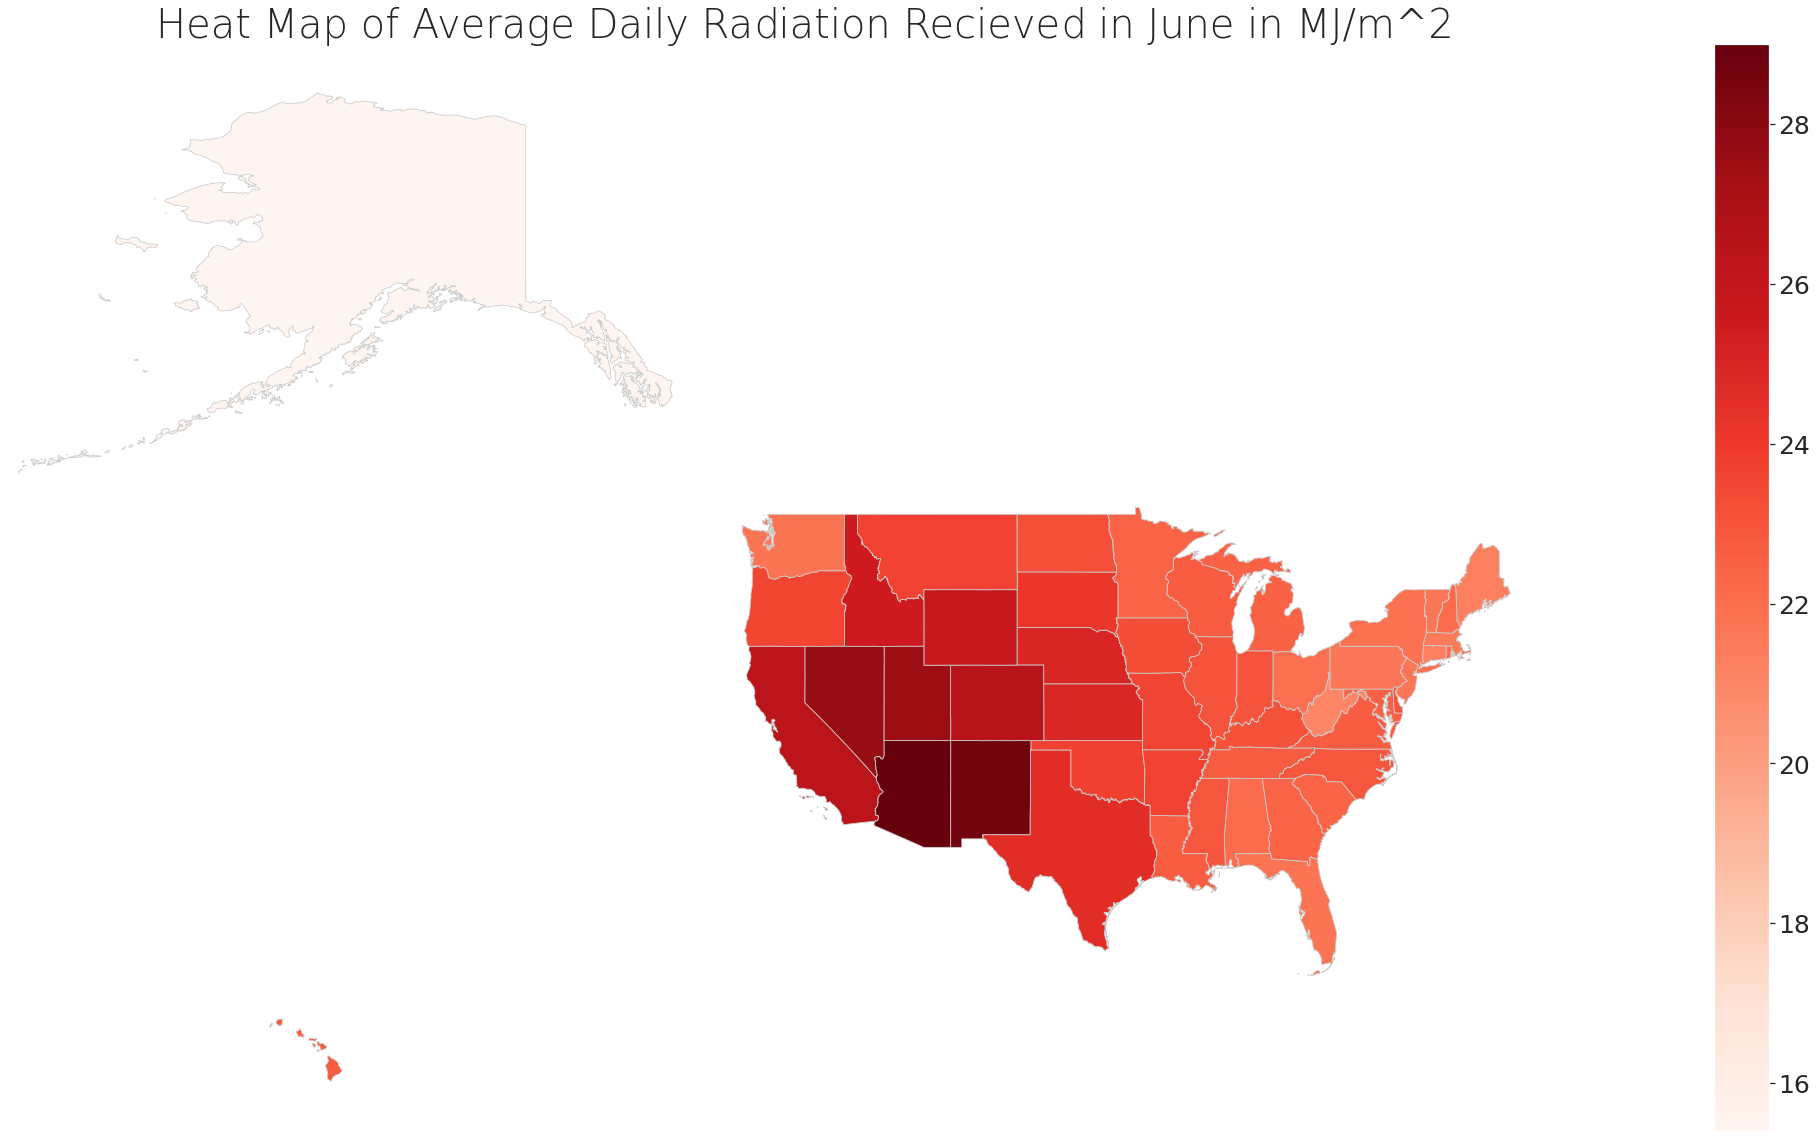

In [22]:
#Repeat by monthy daily average for June
H_bar_state_jun = H_bar_state[:,5];
d_jun = {'State': state, 'Value': H_bar_state_jun};
df_jun = pd.DataFrame(data=d_jun);

merged_jun = US.set_index('STUSPS').join(df_jun.set_index('State'))
merged_jun = merged_jun.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in June in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_jun = df_jun['Value'];
vmin = col_jun.min();
vmax = col_jun.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_jun.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

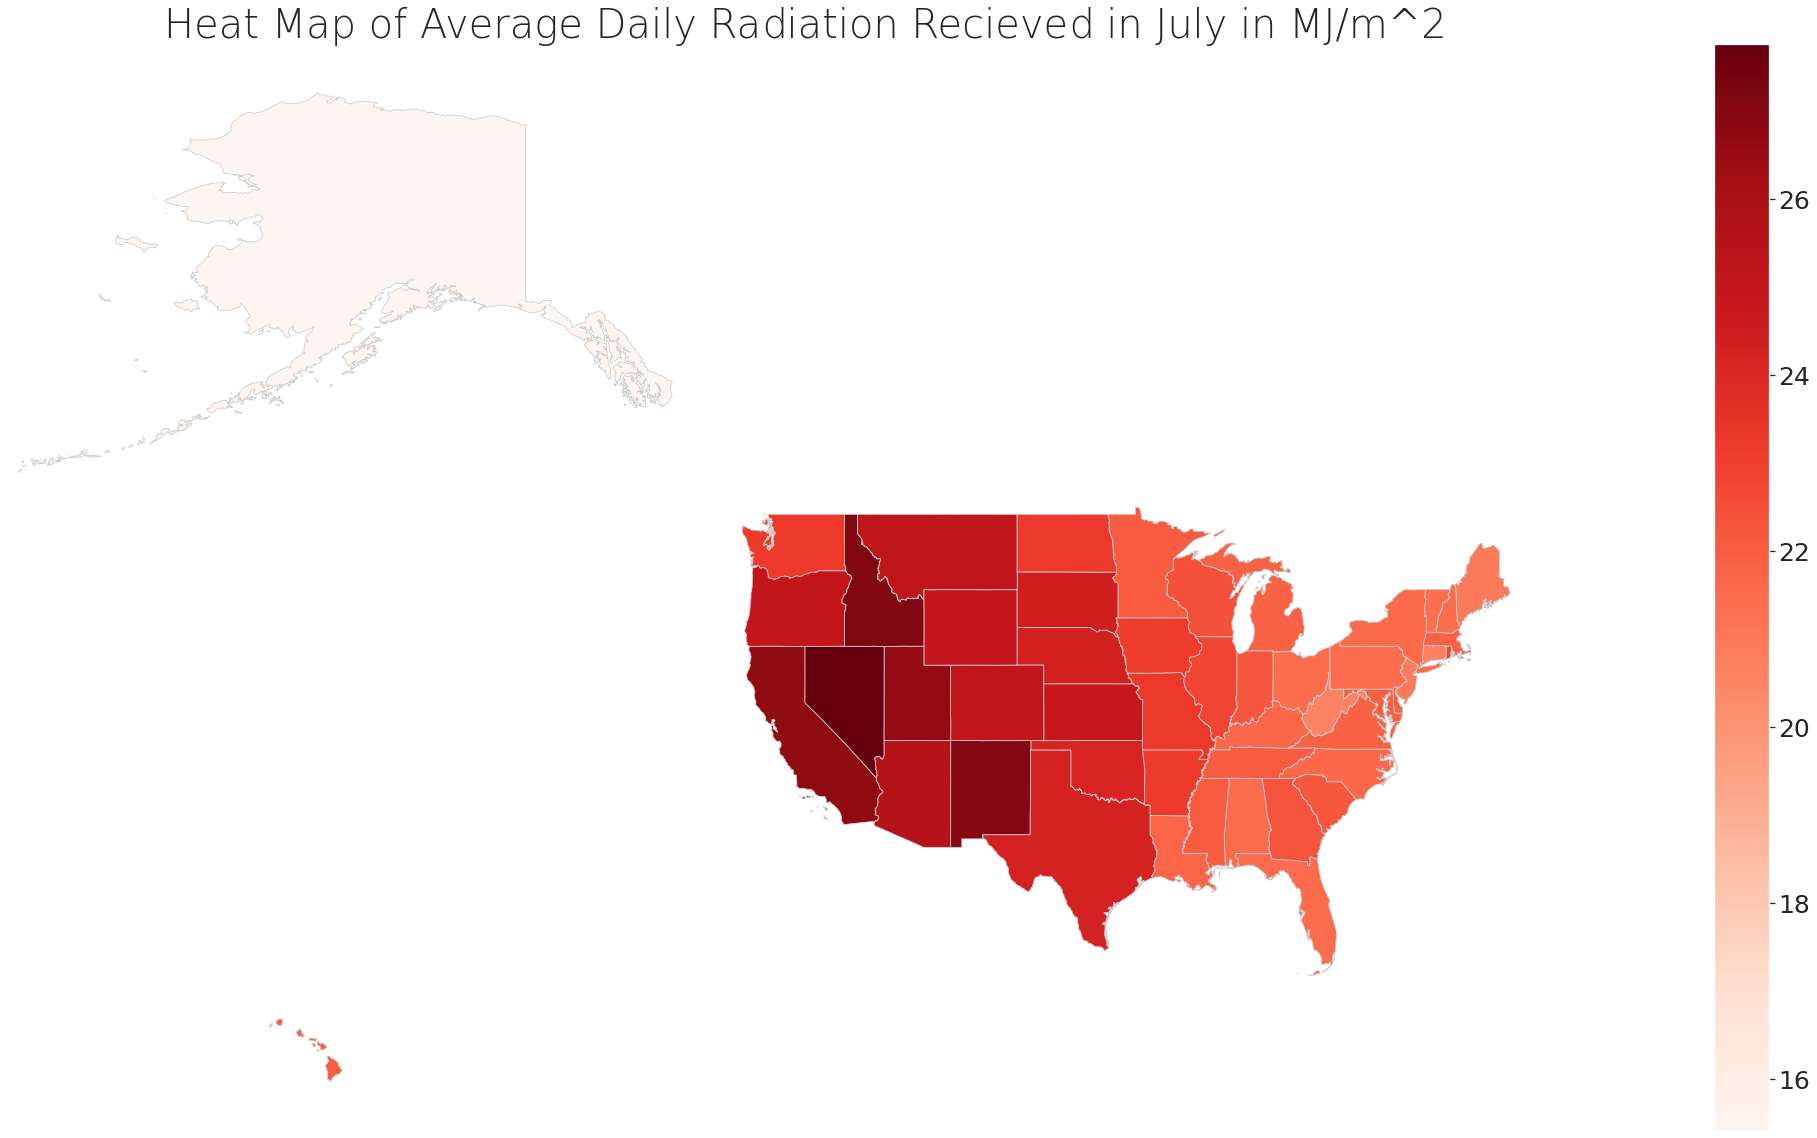

In [23]:
#Repeat by monthy daily average for July
H_bar_state_jul = H_bar_state[:,6];
d_jul = {'State': state, 'Value': H_bar_state_jul};
df_jul = pd.DataFrame(data=d_jul);

merged_jul = US.set_index('STUSPS').join(df_jul.set_index('State'))
merged_jul = merged_jul.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in July in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_jul = df_jul['Value'];
vmin = col_jul.min();
vmax = col_jul.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_jul.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

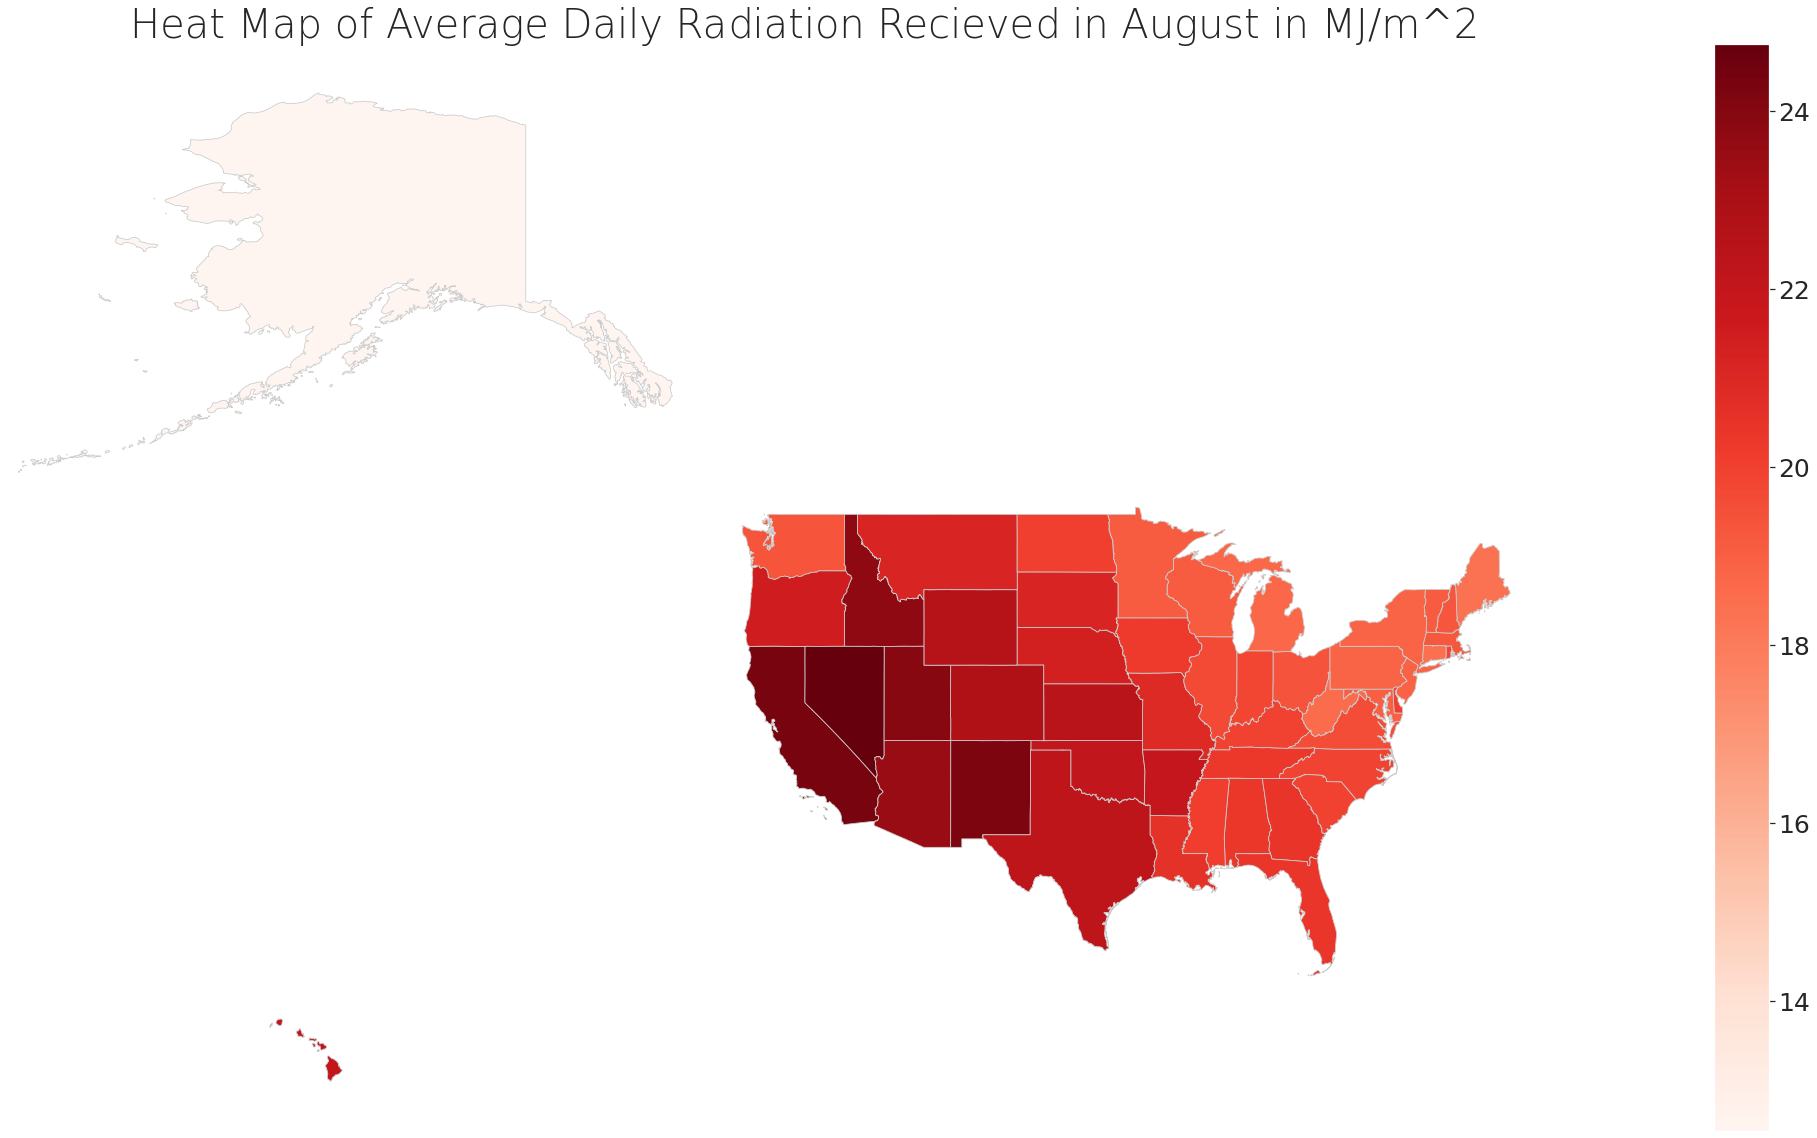

In [24]:
#Repeat by monthy daily average for August
H_bar_state_aug = H_bar_state[:,7];
d_aug = {'State': state, 'Value': H_bar_state_aug};
df_aug = pd.DataFrame(data=d_aug);

merged_aug = US.set_index('STUSPS').join(df_aug.set_index('State'))
merged_aug = merged_aug.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in August in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_aug = df_aug['Value'];
vmin = col_aug.min();
vmax = col_aug.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_aug.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

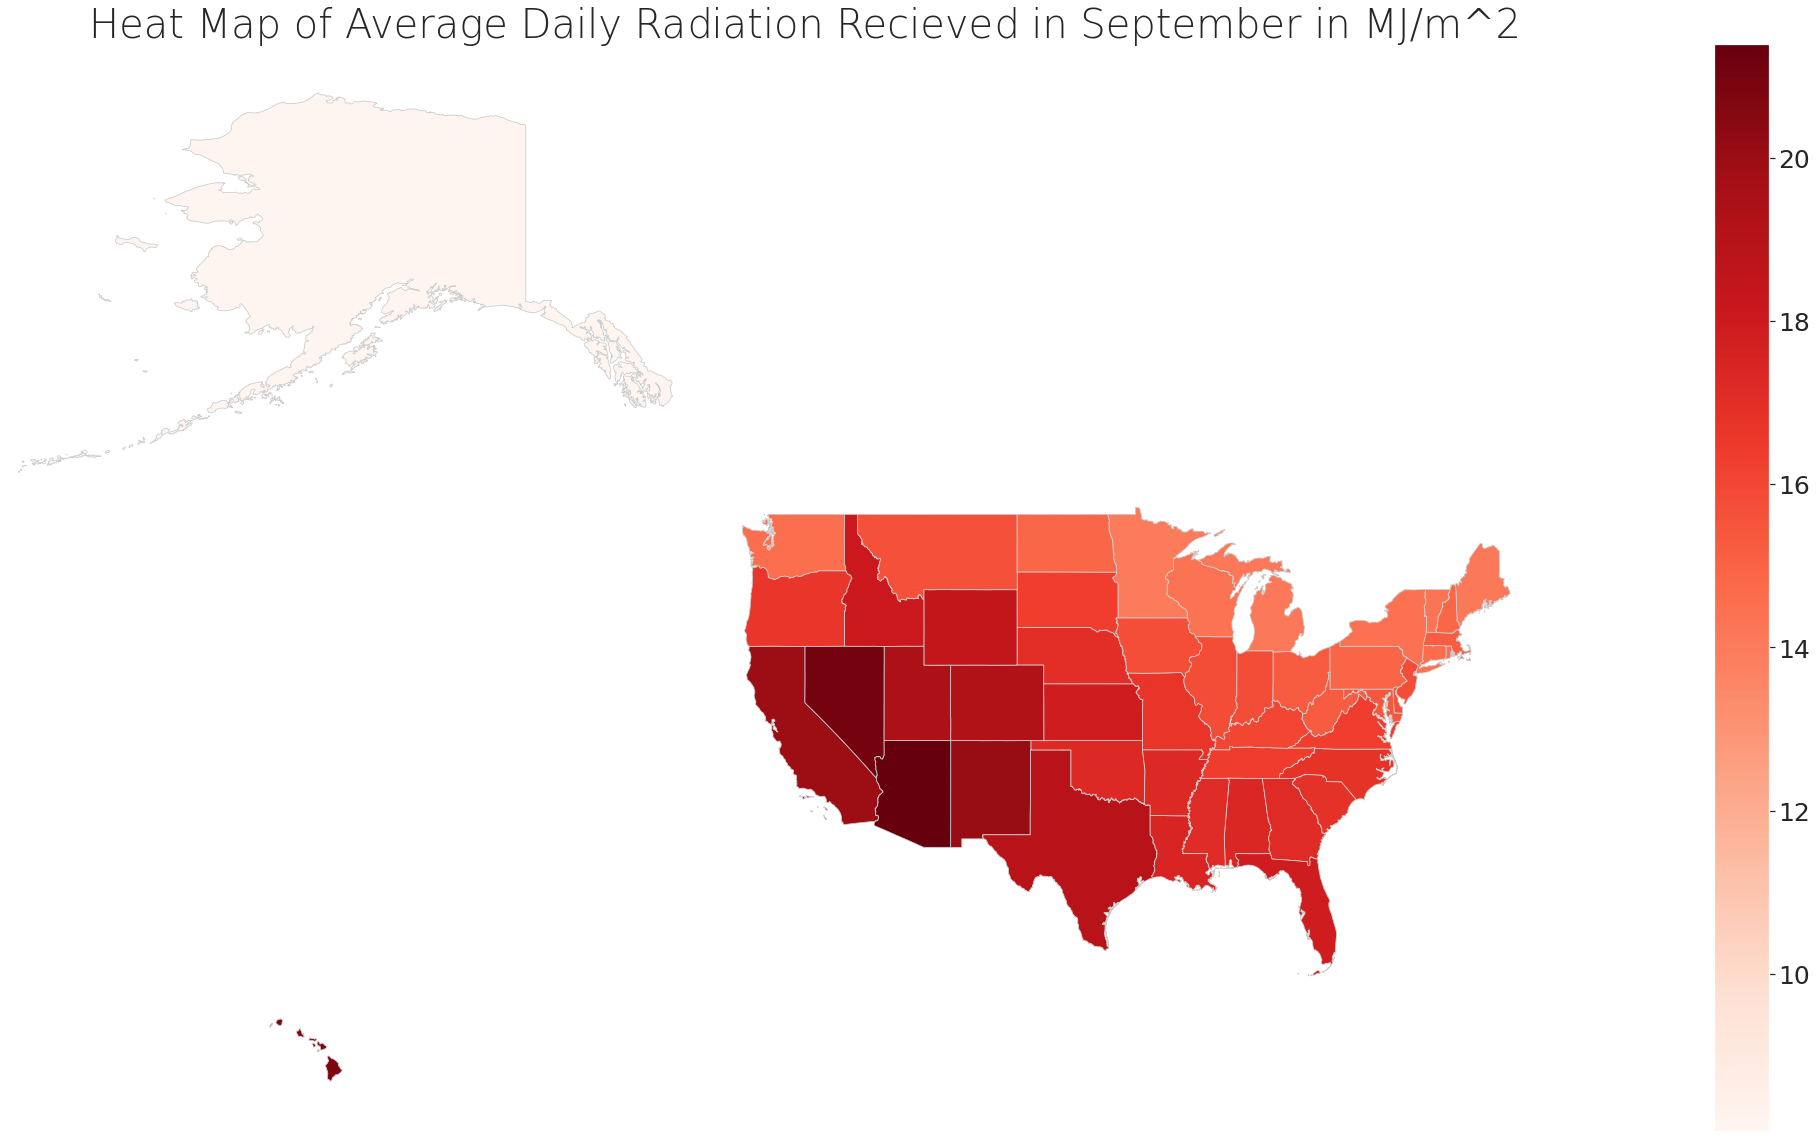

In [25]:
#Repeat by monthy daily average for September
H_bar_state_sep = H_bar_state[:,8];
d_sep = {'State': state, 'Value': H_bar_state_sep};
df_sep = pd.DataFrame(data=d_sep);

merged_sep = US.set_index('STUSPS').join(df_sep.set_index('State'))
merged_sep = merged_sep.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in September in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_sep = df_sep['Value'];
vmin = col_sep.min();
vmax = col_sep.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_sep.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

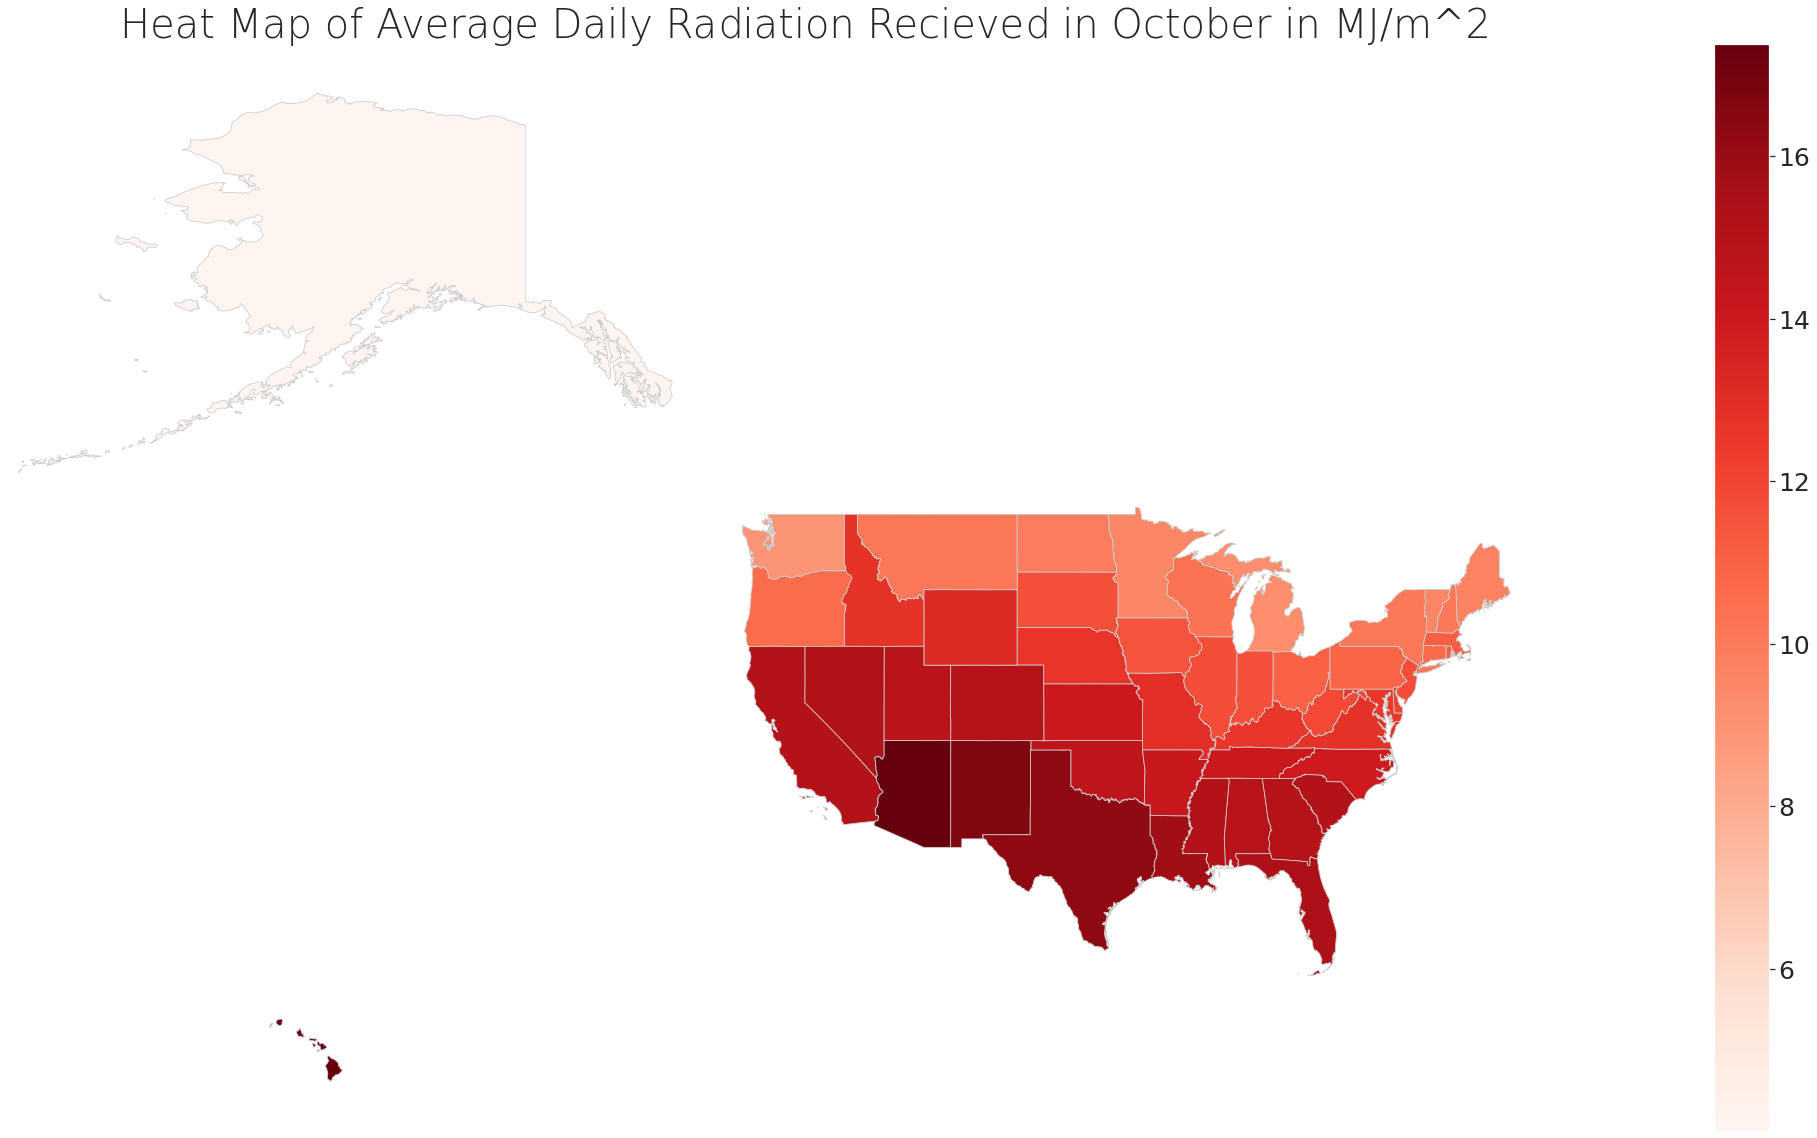

In [26]:
#Repeat by monthy daily average for October
H_bar_state_oct = H_bar_state[:,9];
d_oct = {'State': state, 'Value': H_bar_state_oct};
df_oct = pd.DataFrame(data=d_oct);

merged_oct = US.set_index('STUSPS').join(df_oct.set_index('State'))
merged_oct = merged_oct.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in October in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_oct = df_oct['Value'];
vmin = col_oct.min();
vmax = col_oct.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_oct.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

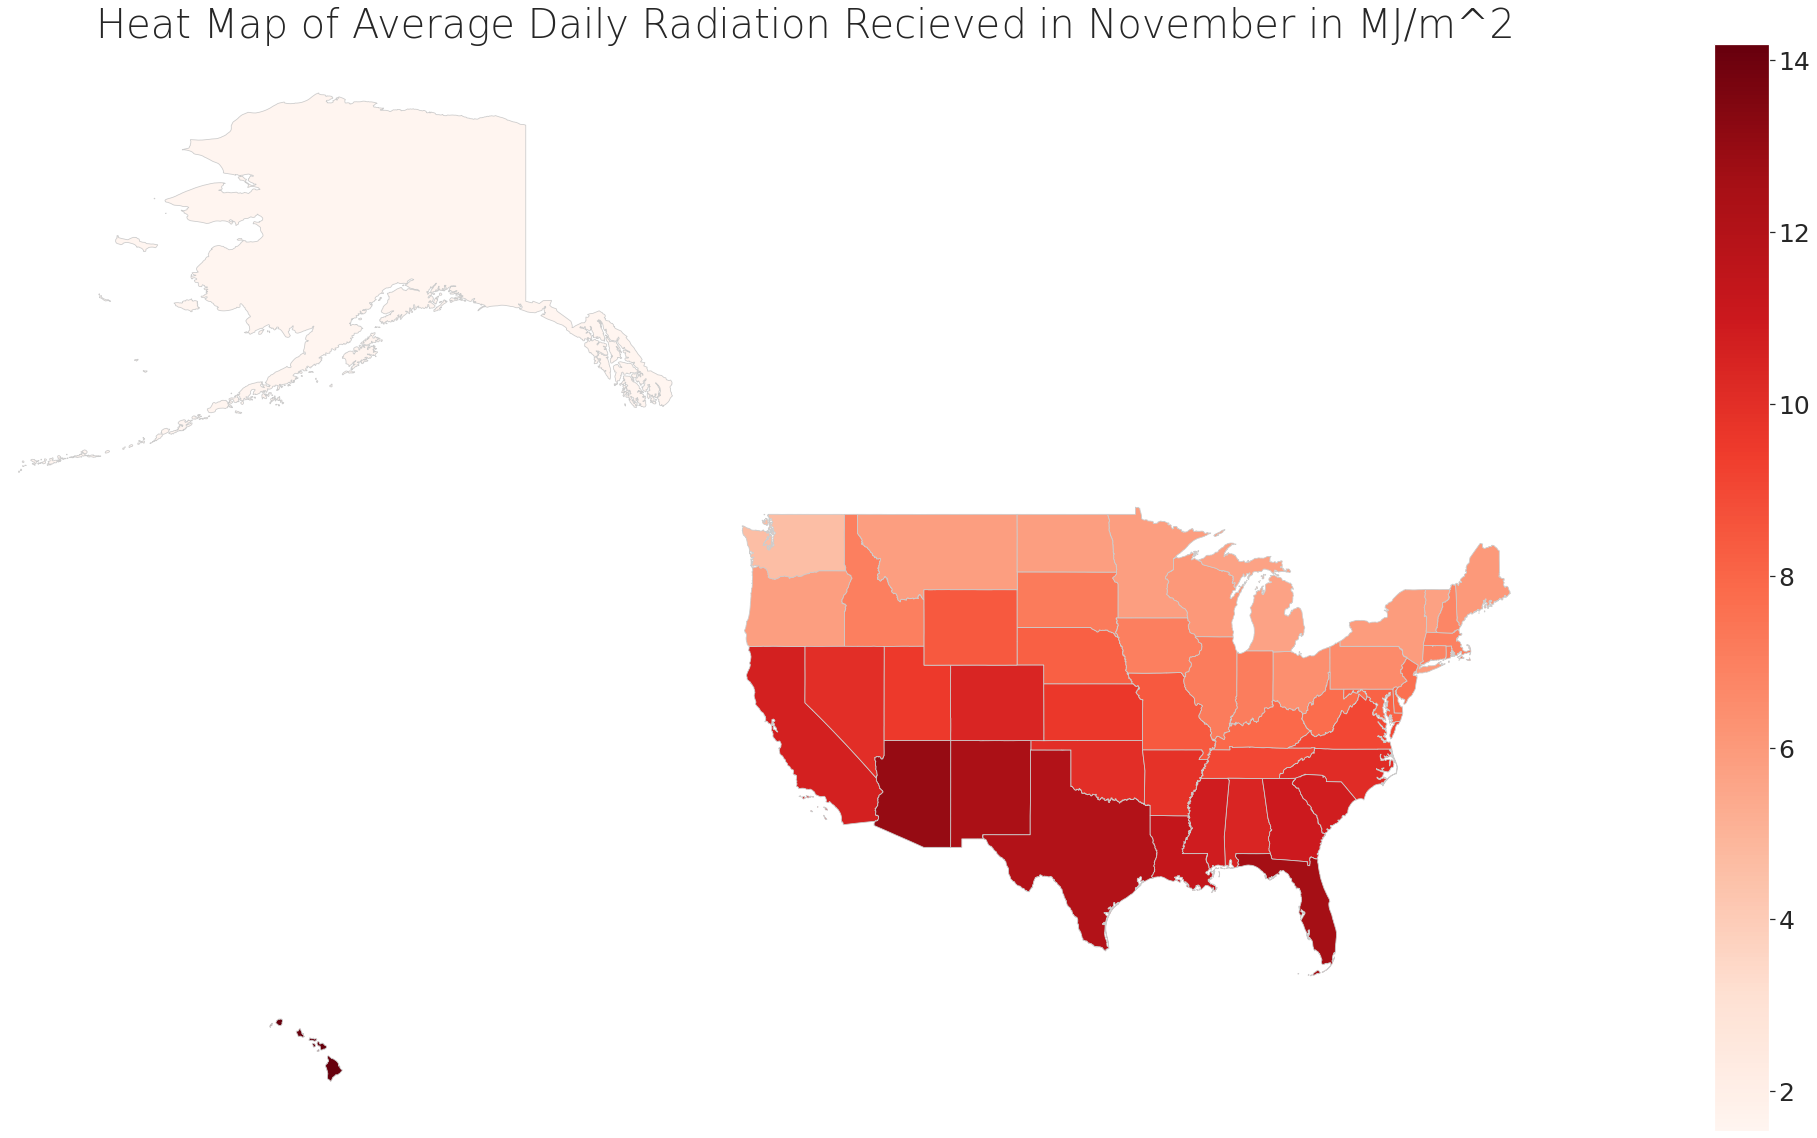

In [27]:
#Repeat by monthy daily average for November
H_bar_state_nov = H_bar_state[:,10];
d_nov = {'State': state, 'Value': H_bar_state_nov};
df_nov = pd.DataFrame(data=d_nov);

merged_nov = US.set_index('STUSPS').join(df_nov.set_index('State'))
merged_nov = merged_nov.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in November in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_nov = df_nov['Value'];
vmin = col_nov.min();
vmax = col_nov.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_nov.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);

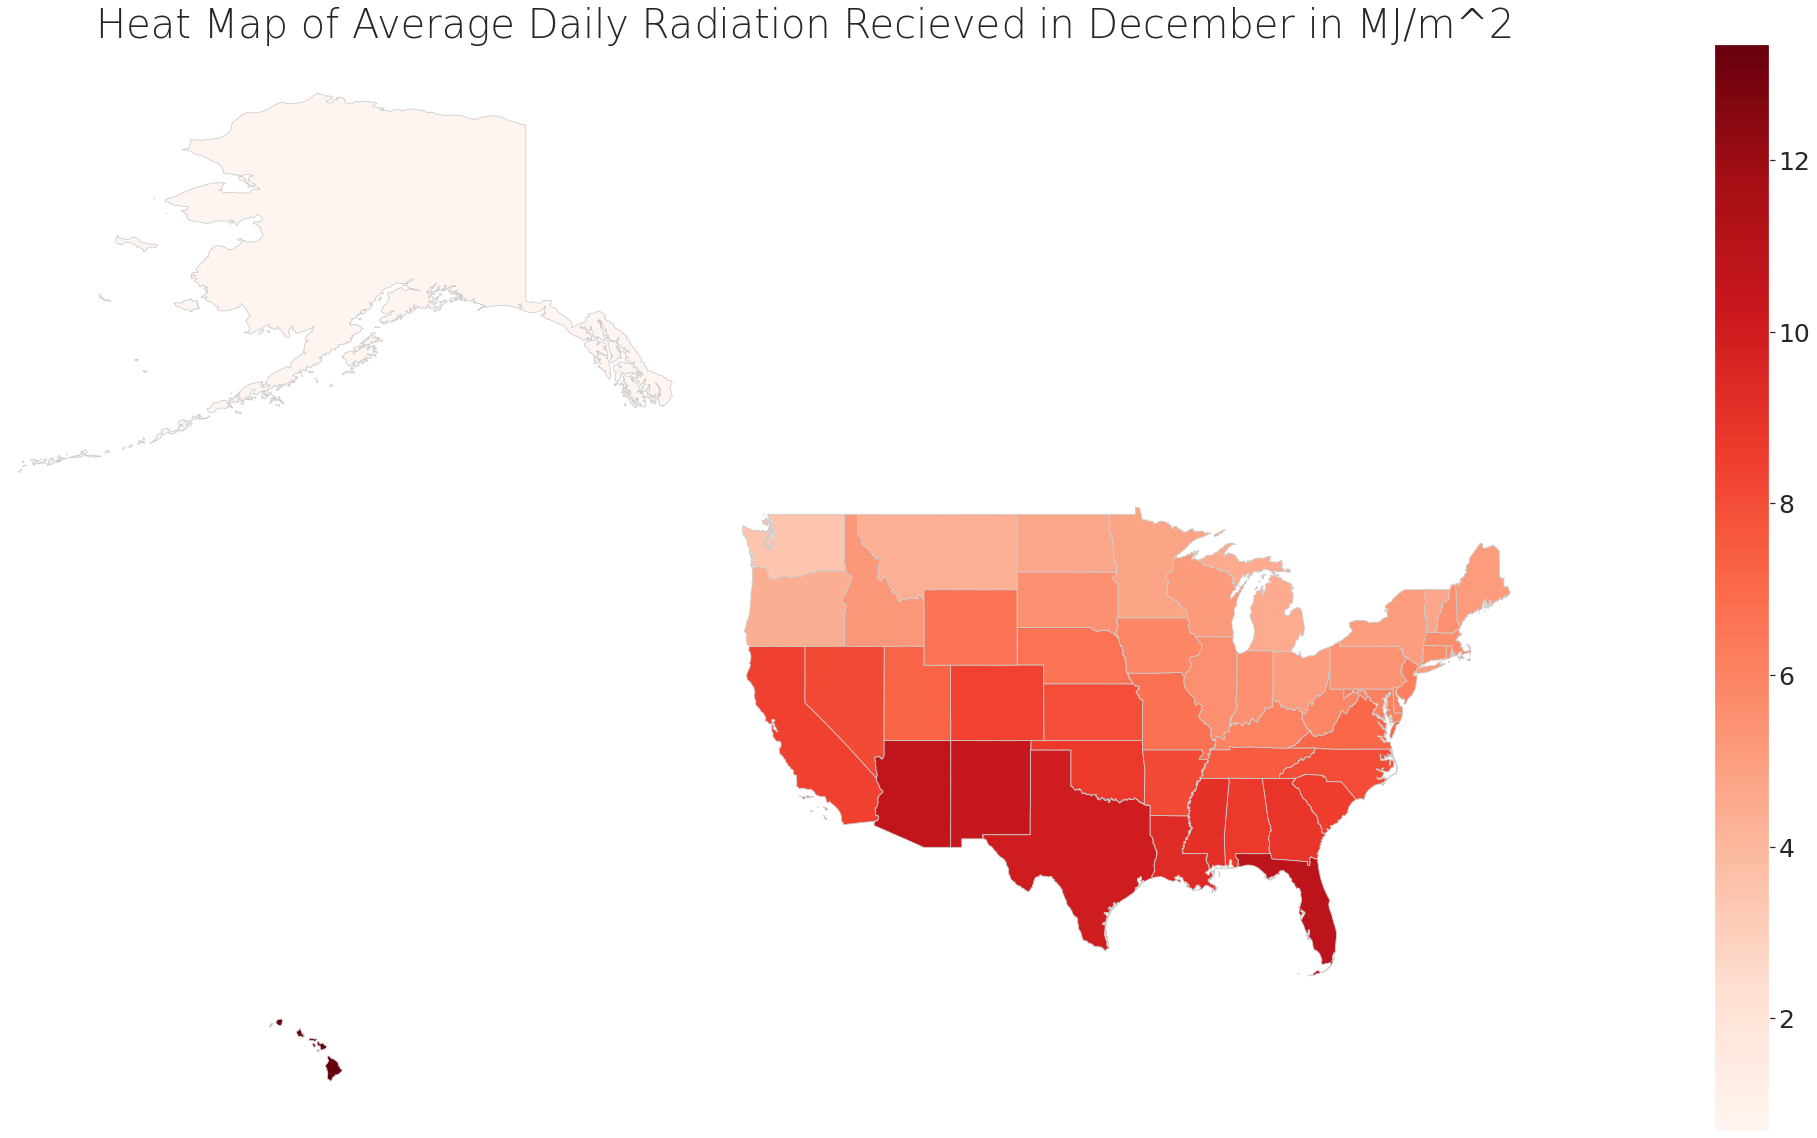

In [28]:
#Repeat by monthy daily average for December
H_bar_state_dec = H_bar_state[:,11];
d_dec = {'State': state, 'Value': H_bar_state_dec};
df_dec = pd.DataFrame(data=d_dec);

merged_dec = US.set_index('STUSPS').join(df_dec.set_index('State'))
merged_dec = merged_dec.reset_index();

fig, ax = plt.subplots(1, figsize=(40, 20));
ax.axis('off');
ax.set_title('Heat Map of Average Daily Radiation Recieved in December in MJ/m^2', fontdict={'fontsize': '40', 'fontweight' : '5'});
color = 'Reds';
col_dec = df_dec['Value'];
vmin = col_dec.min();
vmax = col_dec.max();
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax));
sm._A = [];
cbar = fig.colorbar(sm);
cbar.ax.tick_params(labelsize=25);
merged_dec.plot('Value', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20));
plt.xlim([-180,-60]);